In [58]:
from google.cloud import bigquery
import pandas as pd
from bq_helper import BigQueryHelper
import numpy as np
from scipy import stats

transaction_query = """
SELECT 
  AVG(value) AS value,
  AVG(gas_price) AS gas_price,
  MIN(block_timestamp) AS time
FROM
  `bigquery-public-data.crypto_ethereum.transactions` AS transactions
WHERE DATE(block_timestamp) BETWEEN DATE(2019,12,9) AND DATE(2022,08,17)
GROUP BY CAST(block_timestamp AS STRING FORMAT 'YYYY-MM-DD HH24')
ORDER BY time
"""

In [59]:
blocks_query = """
SELECT 
  AVG(size) AS size,
  AVG(total_difficulty) AS total_diff,
  AVG(difficulty) AS diff,
  AVG(gas_limit) AS blockgas_limit,
  AVG(gas_used) AS blockgas_used,
  AVG(transaction_count) AS trans_count,
  MIN(timestamp) AS time
FROM
  `bigquery-public-data.crypto_ethereum.blocks` AS blocks
WHERE DATE(timestamp) BETWEEN DATE(2019,12,9) AND DATE(2022,08,17)
GROUP BY CAST(timestamp AS STRING FORMAT 'YYYY-MM-DD HH24')
ORDER BY time
"""

In [60]:
# This establishes an authenticated session and prepares a reference to the dataset that lives in BigQuery.
bq_assistant = BigQueryHelper("bigquery-public-data", "crypto_ethereum")

trans = bq_assistant.query_to_pandas_safe(transaction_query, max_gb_scanned=200)
blocks = bq_assistant.query_to_pandas_safe(blocks_query, max_gb_scanned=200)
print('Size of dataframe: {} Bytes'.format(int(trans.memory_usage(index=True, deep=True).sum())))

Using Kaggle's public dataset BigQuery integration.
Size of dataframe: 3019856 Bytes


In [61]:
trans['time'] = pd.to_datetime(trans['time'].astype(str).str[:-6])
blocks['time'] = pd.to_datetime(blocks['time'].astype(str).str[:-6])

In [62]:
blocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23592 entries, 0 to 23591
Data columns (total 7 columns):
size              23592 non-null float64
total_diff        23592 non-null object
diff              23592 non-null object
blockgas_limit    23592 non-null float64
blockgas_used     23592 non-null float64
trans_count       23592 non-null float64
time              23592 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 1.3+ MB


In [63]:
trans.set_index('time', inplace=True)
blocks.set_index('time', inplace=True)

In [115]:
trans['value'] = trans['value'].astype(float)
trans_hr = trans
trans_hr = trans.resample('12H').mean()
trans_hr = trans_hr[(np.abs(stats.zscore(trans_hr)) < 3).all(axis=1)] # 3std dev from mean

In [116]:
blocks['diff'] = blocks['diff'].astype(float)
blocks['total_diff'] = blocks['total_diff'].astype(float)

blocks_hr = blocks
blocks_hr = blocks.resample('12H').mean()
blocks_hr = blocks_hr[(np.abs(stats.zscore(blocks_hr)) < 3).all(axis=1)] # 3std dev from mean

In [117]:
print(trans_hr.isna().sum())
print(blocks_hr.isna().sum())
blocks_hr.info()

value        0
gas_price    0
dtype: int64
size              0
total_diff        0
diff              0
blockgas_limit    0
blockgas_used     0
trans_count       0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1959 entries, 2019-12-09 00:00:00 to 2022-08-17 12:00:00
Data columns (total 6 columns):
size              1959 non-null float64
total_diff        1959 non-null float64
diff              1959 non-null float64
blockgas_limit    1959 non-null float64
blockgas_used     1959 non-null float64
trans_count       1959 non-null float64
dtypes: float64(6)
memory usage: 107.1 KB


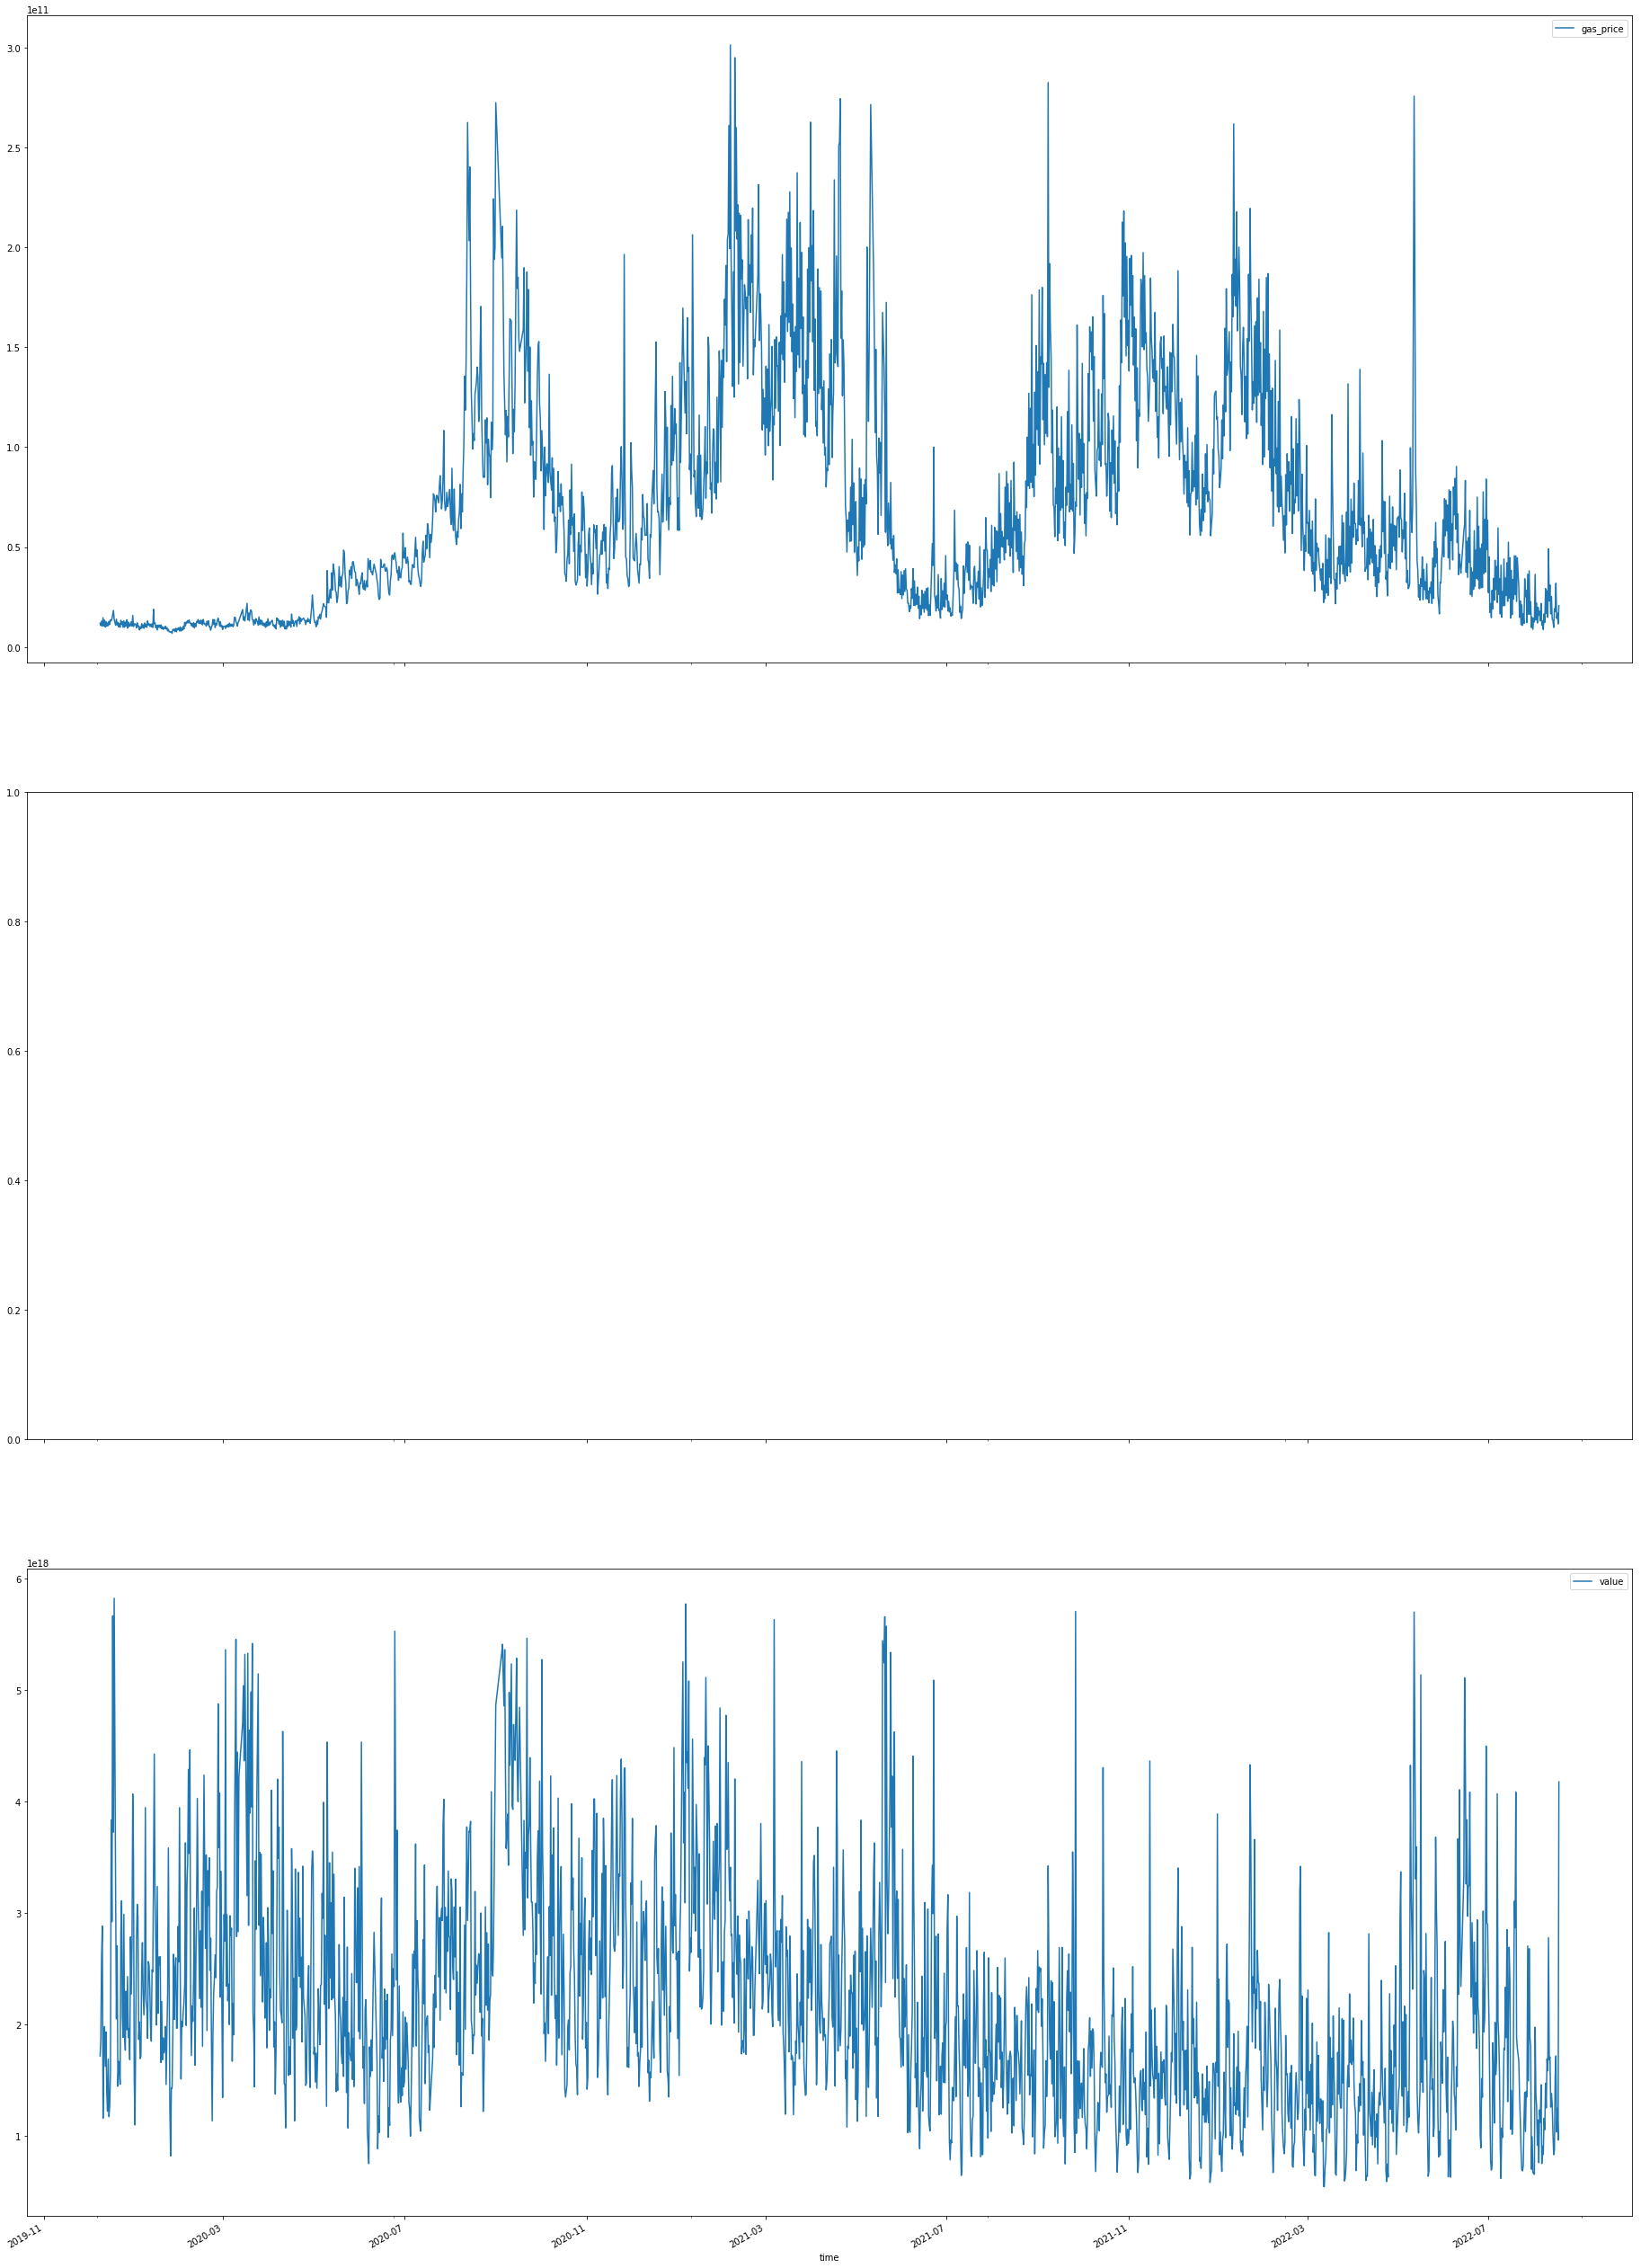

In [118]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, figsize=(32,50), sharex=True)
trans_hr.plot(y='gas_price', ax=ax[0])
#trans_hr.plot(y='gas', ax=ax[1])
trans_hr.plot(y='value', ax=ax[2])

#trace_hr.plot(y='gas_used', ax=ax[3])
#trace_hr.plot(y='gas', ax=ax[4])
#trace_hr.plot(y='value', ax=ax[5])
plt.show()

In [123]:
df = pd.concat([trans_hr, blocks_hr], axis = 1)
print(df.isna().sum())
df = (df.ffill() + df.bfill()) / 2
df

value             47
gas_price         47
size               7
total_diff         7
diff               7
blockgas_limit     7
blockgas_used      7
trans_count        7
dtype: int64


,value,gas_price,size,total_diff,diff,blockgas_limit,blockgas_used,trans_count
time,,,,,,,,
2019-12-09 00:00:00,1.714232e+18,1.188488e+10,26954.196984,1.320578e+22,2.491522e+15,9.978089e+06,8.265007e+06,132.474181
2019-12-09 12:00:00,1.864878e+18,1.065346e+10,23119.128702,1.321282e+22,2.505305e+15,9.949123e+06,7.206299e+06,94.216358
2019-12-10 00:00:00,2.598755e+18,1.289148e+10,27605.078101,1.321992e+22,2.515802e+15,9.971129e+06,8.498842e+06,132.224403
2019-12-10 12:00:00,2.879209e+18,1.051088e+10,22830.284268,1.322731e+22,2.621950e+15,9.960087e+06,7.957343e+06,90.291756
2019-12-11 00:00:00,1.155473e+18,1.460837e+10,26911.388795,1.323463e+22,2.567617e+15,9.974724e+06,8.566689e+06,131.801288
2019-12-11 12:00:00,1.815707e+18,1.050351e+10,22632.271325,1.324157e+22,2.481810e+15,9.963181e+06,8.396264e+06,93.828586
2019-12-12 00:00:00,1.978618e+18,1.344506e+10,26974.399103,1.324859e+22,2.492290e+15,9.978612e+06,8.849216e+06,128.016610
2019-12-12 12:00:00,1.621014e+18,9.983416e+09,22890.121722,1.325572e+22,2.520741e+15,9.967664e+06,8.192045e+06,95.965754
2019-12-13 00:00:00,1.930017e+18,1.268950e+10,26776.260947,1.326300e+22,2.545864e+15,9.972905e+06,8.780155e+06,133.706049


value             0
gas_price         0
size              0
total_diff        0
diff              0
blockgas_limit    0
blockgas_used     0
trans_count       0
dtype: int64


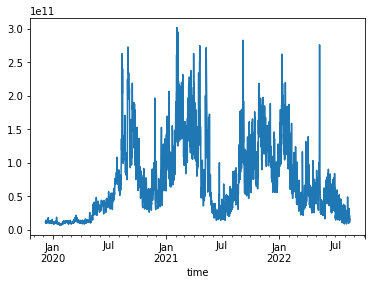

In [124]:
print(df.isna().sum())

df['gas_price'].plot()

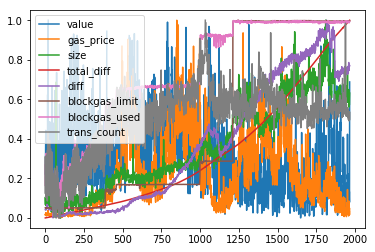

In [121]:
from sklearn import preprocessing
def mmScaler(df):
    col_names = df.columns
    x = df.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    x_scaled = min_max_scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled)
    df.columns = col_names
    return df

df_scaled  = mmScaler(df)
df_scaled.plot()

In [125]:
df.to_csv("eth_kaggle_info.csv")

In [126]:
df.tail()

,value,gas_price,size,total_diff,diff,blockgas_limit,blockgas_used,trans_count
time,,,,,,,,
2022-08-15 12:00:00,1.714696e+18,3.187493e+10,84682.267655,5.643731e+22,1.191417e+16,3.000266e+07,1.539400e+07,177.287879
2022-08-16 00:00:00,1.032394e+18,1.429751e+10,84837.624544,5.647567e+22,1.217935e+16,3.000294e+07,1.543248e+07,169.310089
2022-08-16 12:00:00,1.244169e+18,1.688449e+10,79042.068110,5.651439e+22,1.226842e+16,3.000374e+07,1.545096e+07,171.427925
2022-08-17 00:00:00,9.596503e+17,1.150712e+10,81622.926271,5.655346e+22,1.227023e+16,2.999973e+07,1.545133e+07,178.740731
2022-08-17 12:00:00,4.173759e+18,2.061967e+10,85670.836854,5.659245e+22,1.223954e+16,3.000493e+07,1.545876e+07,170.836381
